# **FINAL PROJECT SQL - Pacmann Academy**
## Dharmayuda Febrianto - ADS Batch 14

## **Import Package Libraries**

In [1]:
import sqlite3 # Accesing database
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # data visualization
from plotly.subplots import make_subplots # data visualization
import warnings
warnings.filterwarnings("ignore")

## **Accessing Data**

In [2]:
def get_result(query):
    conn = sqlite3.connect("olist.db")
    cursor = conn.cursor()
    cursor.execute(query)
    data = cursor.fetchall()
    conn.close()
    return(data)

def create_list_of_table_df(data, columns):
    processData = pd.DataFrame(data=data, columns=columns)
    processData.columns = ["Table Name"]
    return processData

def create_df(data, columns):
    processData = pd.DataFrame(data = data, columns = columns).drop("index", axis = 1)
    # Reset the column index
    processData = processData.reset_index(drop = True)
    # Join the multi-index levels to create a single column index 
    processData.columns = [''.join(col).strip() for col in processData.columns.values] 
    return(processData)

Pada cells code di bawah digunakan untuk membuat list table dataframe yang berasal dari `olist.db`, kemudian beberapa tabel data yang ada pada `olist.db` dikategorikan ke dalam beberapa nama dataframe yang sesuai dengan tabel data yang termuat

In [3]:
# See the table list 
list_of_table = get_result("SELECT name FROM sqlite_master WHERE type='table';")
list_of_table_df = create_list_of_table_df(list_of_table, columns=["Table Name"])
list_of_table_df

# Retrieve all dataset
olist_order_customer = create_df(get_result("SELECT * FROM olist_order_customer_dataset"), [["index","customers_id","customers_uniq_id","customers_zip_code_prefix","customer_city","customer_state"]])
olist_order = create_df(get_result("SELECT * FROM olist_order_dataset"), [["index","order_id","customer_id","order_status","order_purchase_timestamp","order_approved_at","order_delivered_carrier_date","order_delivered_customer_date","order_estimated_delivery_date"]])
olist_order_reviews = create_df(get_result("SELECT * FROM olist_order_reviews_dataset"), [["index","review_id","order_id","review_score","review_comment_title","review_comment_message","review_creation_date","review_answer_timestamp"]])
olist_order_payments = create_df(get_result("SELECT * FROM olist_order_payments_dataset"), [["index","order_id","payment_sequential","payment_type","payment_installments","payment_value"]])
olist_order_items = create_df(get_result("SELECT * FROM olist_order_items_dataset"), [["index","order_id","order_item_id","product_id","seller_id","shipping_limit_date","price","freight_value"]])
olist_products = create_df(get_result("SELECT * FROM olist_products_dataset"), [["index","product_id","product_category_name","product_name_length","product_description_length","product_photos_qty","product_weight_g","product_length_cm","product_height_cm","product_width_cm"]])
olist_sellers = create_df(get_result("SELECT * FROM olist_sellers_dataset"), [["index","seller_id","seller_zip_code_prefix","seller_city","seller_state"]])
olist_geolocation = create_df(get_result("SELECT * FROM olist_geolocation_dataset"), [["index","geolocation_zip_code_prefix","geolocation_lat","geolocation_lng","geolocation_city","geolocation_state"]])
olist_products_eng = create_df(get_result("SELECT * FROM product_category_name_translation"), [["index","product_category_name","product_category_name_english"]])

Setelah dilakukan pengkategorian terhadap tabel dataframe maka kita bisa mengubah semua dataframe yang termuat di dalam variabel di atas ke dalam format `.csv` untuk mempermudah dalam akses dataset masing masing

In [4]:
# Convert all dataframe into csv
olist_order_customer.to_csv('olist_order_customer.csv', index=False)
olist_order.to_csv('olist_order.csv', index=False)
olist_order_reviews.to_csv('olist_order_reviews.csv', index=False)
olist_order_payments.to_csv('olist_order_payments.csv', index=False)
olist_order_items.to_csv('olist_order_items.csv', index=False)
olist_products.to_csv('olist_products.csv', index=False)
olist_sellers.to_csv('olist_sellers.csv', index=False)
olist_geolocation.to_csv('olist_geolocation.csv', index=False)
olist_products_eng.to_csv('olist_products_eng.csv', index=False)

## **Load Dataset**

In [5]:
customers = pd.read_csv('olist_order_customer.csv')
orders = pd.read_csv('olist_order.csv')
order_reviews = pd.read_csv('olist_order_reviews.csv')
payments = pd.read_csv('olist_order_payments.csv')
order_items = pd.read_csv('olist_order_items.csv')
products = pd.read_csv('olist_products.csv')
sellers = pd.read_csv('olist_sellers.csv')
geolocation = pd.read_csv('olist_geolocation.csv')
products_eng = pd.read_csv('olist_products_eng.csv')

## **Data Wrangling, Data Cleaning, Data Manipulation, Data Preprocessing**

In [6]:
# Menampilkan dtype pada tabel order
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [7]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [8]:
is_delivered_orders = orders[orders['order_status'] == 'delivered'] # menselect orders yang 'deliver'

is_delivered_orders = is_delivered_orders.reset_index(drop = True) # reset index kolom

# mengdrop kolom yang tidak di gunakan pada analisis order
dropped_column = ['order_delivered_carrier_date', 'order_delivered_customer_date', 'order_approved_at', 'order_estimated_delivery_date']
is_delivered_orders = is_delivered_orders.drop(dropped_column, axis=1)
is_delivered_orders['order_purchase_timestamp'] = pd.to_datetime(is_delivered_orders['order_purchase_timestamp'])
is_delivered_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96478 entries, 0 to 96477
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  96478 non-null  object        
 1   customer_id               96478 non-null  object        
 2   order_status              96478 non-null  object        
 3   order_purchase_timestamp  96478 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 2.9+ MB


In [9]:
# Identifikasi Missing Values 
is_delivered_orders.isna().sum().to_frame().reset_index().rename(columns={'index':'column_name', 0:'value'})

,column_name,value
0,order_id,0
1,customer_id,0
2,order_status,0
3,order_purchase_timestamp,0


In [10]:
# Identifikasi Duplicated Data
is_delivered_orders[is_delivered_orders.duplicated(keep=False)]

,order_id,customer_id,order_status,order_purchase_timestamp


In [11]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   customers_id               99441 non-null  object
 1   customers_uniq_id          99441 non-null  object
 2   customers_zip_code_prefix  99441 non-null  int64 
 3   customer_city              99441 non-null  object
 4   customer_state             99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


karena kolom customer id pada dataframe customer tidak sesuai dengan dataframe yang lainnya, maka kita perlu merename namanya agar bisa kita merge dengan dataframe yang lain:

In [12]:
customers = customers.rename(columns={'customers_id': 'customer_id'})
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   customer_id                99441 non-null  object
 1   customers_uniq_id          99441 non-null  object
 2   customers_zip_code_prefix  99441 non-null  int64 
 3   customer_city              99441 non-null  object
 4   customer_state             99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [13]:
# Identifikasi Missing Values
customers.isna().sum().to_frame().reset_index().rename(columns={'index':'column_name', 0:'value'})

,column_name,value
0,customer_id,0
1,customers_uniq_id,0
2,customers_zip_code_prefix,0
3,customer_city,0
4,customer_state,0


In [14]:
# Identifying duplicates values
customers[customers.duplicated(keep=False)]

,customer_id,customers_uniq_id,customers_zip_code_prefix,customer_city,customer_state


In [15]:
# Identifikasi Value pada kolom customer_state
customers.customer_state.value_counts()

SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: customer_state, dtype: int64

In [16]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [17]:
# Identifikasi Missing Values
payments.isna().sum().to_frame().reset_index().rename(columns={'index':'column_name', 0:'value'})

,column_name,value
0,order_id,0
1,payment_sequential,0
2,payment_type,0
3,payment_installments,0
4,payment_value,0


In [18]:
# Identifikasi Duplicated Values
payments[payments.duplicated(keep=False)]

,order_id,payment_sequential,payment_type,payment_installments,payment_value


In [19]:
# Identifikasi Value Pada Kolom payment_type
payments.payment_type.value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

In [20]:
# Select Data not defined pada Kolom payment_type
payments[payments['payment_type'] == 'not_defined']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0


In [21]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   customer_id                99441 non-null  object
 1   customers_uniq_id          99441 non-null  object
 2   customers_zip_code_prefix  99441 non-null  int64 
 3   customer_city              99441 non-null  object
 4   customer_state             99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [22]:
# Merge tabel order dan customers dan menyimpannya pada tabel revenue_states
revenue_states = pd.merge(is_delivered_orders, customers, how='left', on='customer_id')

# Merge tabel order dan payments dan menyimpannya pada tabel revenue_states
revenue_states = pd.merge(revenue_states, payments, how='left', on='order_id')
revenue_states

,order_id,customer_id,order_status,order_purchase_timestamp,customers_uniq_id,customers_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,credit_card,3.0,179.12
...,...,...,...,...,...,...,...,...,...,...,...,...
100752,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,1.0,credit_card,3.0,85.08
100753,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1.0,credit_card,3.0,195.00
100754,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1.0,credit_card,5.0,271.01
100755,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1.0,credit_card,4.0,441.16


In [23]:
revenue_states.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100757 entries, 0 to 100756
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   order_id                   100757 non-null  object        
 1   customer_id                100757 non-null  object        
 2   order_status               100757 non-null  object        
 3   order_purchase_timestamp   100757 non-null  datetime64[ns]
 4   customers_uniq_id          100757 non-null  object        
 5   customers_zip_code_prefix  100757 non-null  int64         
 6   customer_city              100757 non-null  object        
 7   customer_state             100757 non-null  object        
 8   payment_sequential         100756 non-null  float64       
 9   payment_type               100756 non-null  object        
 10  payment_installments       100756 non-null  float64       
 11  payment_value              100756 non-null  float64 

In [24]:
# Descriptif Statistik dari payment_value pada tabel revenue_states
revenue_states['payment_value'].describe(include='all')

count    100756.000000
mean        153.067428
std         214.451418
min           0.000000
25%          56.780000
50%         100.000000
75%         171.290000
max       13664.080000
Name: payment_value, dtype: float64

In [25]:
# Identifikasi Missing Values
revenue_states.isna().sum().to_frame().reset_index().rename(columns={'index':'column_name', 0:'value'})

,column_name,value
0,order_id,0
1,customer_id,0
2,order_status,0
3,order_purchase_timestamp,0
4,customers_uniq_id,0
5,customers_zip_code_prefix,0
6,customer_city,0
7,customer_state,0
8,payment_sequential,1
9,payment_type,1


In [26]:
# Menampilkan isian Missing Values pada tabel revenue_states
revenue_states[revenue_states.isna().any(axis=1)]

,order_id,customer_id,order_status,order_purchase_timestamp,customers_uniq_id,customers_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
31175,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,NaN,NaN,NaN,NaN


In [27]:
# Drop Misiing Values
revenue_states = revenue_states.dropna()

In [28]:
# Identifikasi Duplicated Values
revenue_states[revenue_states.duplicated(keep=False)]

,order_id,customer_id,order_status,order_purchase_timestamp,customers_uniq_id,customers_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value


### **Tabel Objective 1 dan 2** 

In [29]:
revenue_states

,order_id,customer_id,order_status,order_purchase_timestamp,customers_uniq_id,customers_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,credit_card,3.0,179.12
...,...,...,...,...,...,...,...,...,...,...,...,...
100752,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,1.0,credit_card,3.0,85.08
100753,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1.0,credit_card,3.0,195.00
100754,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1.0,credit_card,5.0,271.01
100755,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1.0,credit_card,4.0,441.16


In [99]:
revenue_states.customer_state.value_counts()

SP    42308
RJ    13004
MG    11804
RS     5544
PR     5129
SC     3661
BA     3483
DF     2142
ES     2068
GO     2047
PE     1667
CE     1341
PA      981
MT      909
MA      735
MS      722
PB      551
RN      511
PI      504
AL      411
SE      344
TO      295
RO      251
AM      151
AC       83
AP       69
RR       41
Name: customer_state, dtype: int64

#### **Membuat Tabel ke-2**

In [30]:
# Membuat Tabel order_states ('order_id', 'order_status', 'order_purchase_timestamp', 'customer_state')
is_order_states = revenue_states[['order_id', 'order_status', 'order_purchase_timestamp', 'customer_state']]
is_order_states

,order_id,order_status,order_purchase_timestamp,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,SP
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,SP
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,SP
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,BA
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,GO
...,...,...,...,...
100752,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09 09:54:05,SP
100753,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,SP
100754,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,BA
100755,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,RJ


In [31]:
# Identifikasi Duplicated Values
is_order_states[is_order_states.duplicated(keep=False)]

,order_id,order_status,order_purchase_timestamp,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,SP
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,SP
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,SP
10,e69bfb5eb88e0ed6a785585b27e16dbf,delivered,2017-07-29 11:55:02,SP
11,e69bfb5eb88e0ed6a785585b27e16dbf,delivered,2017-07-29 11:55:02,SP
...,...,...,...,...
100657,4bafa54db6b060da198f23f810835969,delivered,2018-04-05 14:46:51,PA
100747,9115830be804184b91f5c00f6f49f92d,delivered,2017-10-04 19:57:37,MT
100748,9115830be804184b91f5c00f6f49f92d,delivered,2017-10-04 19:57:37,MT
100749,aa04ef5214580b06b10e2a378300db44,delivered,2017-01-27 00:30:03,MG


In [32]:
# Mengdrop Duplicated Values
is_order_states = is_order_states.drop_duplicates(keep='first')

is_order_states = is_order_states.reset_index(drop=True)
is_order_states.info()

shape = is_order_states.shape
print(f'Bentuk Dataframe Order States adalah: {shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96477 entries, 0 to 96476
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  96477 non-null  object        
 1   order_status              96477 non-null  object        
 2   order_purchase_timestamp  96477 non-null  datetime64[ns]
 3   customer_state            96477 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.9+ MB
Bentuk Dataframe Order States adalah: (96477, 4)


#### Tabel Ke-2

In [33]:
is_order_states

,order_id,order_status,order_purchase_timestamp,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,SP
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,BA
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,SP
...,...,...,...,...
96472,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09 09:54:05,SP
96473,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,SP
96474,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,BA
96475,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,RJ


### **Membuat Tabel ke-3**

In [34]:
products.head()

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [35]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_length         32341 non-null  float64
 3   product_description_length  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [36]:
products_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [37]:
# Merge tabel products dan products_eng_table dan menyimpannya ke dalam tabel is_merged_product
is_merged_product = pd.merge(products, products_eng, how='left', on='product_category_name')

# Merge tabel revenue_states dan order_items dan menyimpannya ke dalam tabel is_revenue_order_items
is_revenue_order_items = pd.merge(revenue_states, order_items, how='left', on='order_id')

# Merge tabel is_revenue_order_items dan is_merged_product dan menyimpannya ke dalam tabel is_revenue_products
is_revenue_products = pd.merge(is_revenue_order_items, is_merged_product, how='left', on='product_id')

is_revenue_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115035 entries, 0 to 115034
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115035 non-null  object        
 1   customer_id                    115035 non-null  object        
 2   order_status                   115035 non-null  object        
 3   order_purchase_timestamp       115035 non-null  datetime64[ns]
 4   customers_uniq_id              115035 non-null  object        
 5   customers_zip_code_prefix      115035 non-null  int64         
 6   customer_city                  115035 non-null  object        
 7   customer_state                 115035 non-null  object        
 8   payment_sequential             115035 non-null  float64       
 9   payment_type                   115035 non-null  object        
 10  payment_installments           115035 non-null  float64       
 11  

In [38]:
# dalam analisis membutuhkan 11 kolom yang digunakan pada tabel sebelumnya
is_revenue_products = is_revenue_products[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'customer_state', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'product_id', 'product_category_name_english']]
is_revenue_products.columns = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'customer_state', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'product_id', 'product_category']
is_revenue_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115035 entries, 0 to 115034
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  115035 non-null  object        
 1   customer_id               115035 non-null  object        
 2   order_status              115035 non-null  object        
 3   order_purchase_timestamp  115035 non-null  datetime64[ns]
 4   customer_state            115035 non-null  object        
 5   payment_sequential        115035 non-null  float64       
 6   payment_type              115035 non-null  object        
 7   payment_installments      115035 non-null  float64       
 8   payment_value             115035 non-null  float64       
 9   product_id                115035 non-null  object        
 10  product_category          113384 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 10.5+ M

In [39]:
# Identifikasi Missing Values
is_revenue_products.isna().sum().to_frame().reset_index().rename(columns={'index':'column_name', 0:'value'})

,column_name,value
0,order_id,0
1,customer_id,0
2,order_status,0
3,order_purchase_timestamp,0
4,customer_state,0
5,payment_sequential,0
6,payment_type,0
7,payment_installments,0
8,payment_value,0
9,product_id,0


In [40]:
# Mendefinikasikan rows yang terdapat missing values
miss = is_revenue_products[is_revenue_products.isna().any(axis=1)]
miss

,order_id,customer_id,order_status,order_purchase_timestamp,customer_state,payment_sequential,payment_type,payment_installments,payment_value,product_id,product_category
126,bfe42c22ecbf90bc9f35cf591270b6a7,803ac05904124294f8767894d6da532b,delivered,2018-01-27 22:04:34,MG,1.0,credit_card,1.0,42.40,71225f49be70df4297892f6a5fa62171,NaN
215,58ac1947c1a9067b9f416cba6d844a3f,ee8e1d37f563ecc11cc4dcb4dfd794c2,delivered,2017-09-13 09:18:50,SP,1.0,credit_card,5.0,124.16,9820e04e332fc450d6fd975befc1bc28,NaN
268,e22b71f6e4a481445ec4527cb4c405f7,1faf89c8f142db3fca6cf314c51a37b6,delivered,2017-04-22 13:48:18,MG,1.0,credit_card,3.0,34.24,3bc5164bc7f4be77002d6651da65c98c,NaN
309,a094215e786240fcfefb83d18036a1cd,86acfb656743da0c113d176832c9d535,delivered,2018-02-08 18:56:45,SP,1.0,credit_card,1.0,132.05,5a848e4ab52fd5445cdc07aab1c40e48,NaN
381,6f841dde94727854eaff3f66432c80ea,a9c9532060c9d245f06526c633d2dfba,delivered,2018-01-02 19:20:35,RJ,1.0,credit_card,3.0,192.95,c600d7f13104e8db2ca2b9fa78581409,NaN
...,...,...,...,...,...,...,...,...,...,...,...
114603,1a10e938a1c7d8e5eecc3380f71ca76b,8a81607347c25d881d995d94de6ad824,delivered,2018-07-25 08:58:35,RJ,1.0,boleto,1.0,146.19,8d39a63db6a98e40571f486e0c711cf7,NaN
114773,e33865519137f5737444109ae8438633,64b086bdcc54458af3ea3bd838db54a5,delivered,2018-05-28 00:44:06,SP,1.0,boleto,1.0,42.14,e9cbc0910ab050cbd92fbeb051c270ea,NaN
114780,f0dd9af88d8ef5a8e4670fbbedaf19c4,30ddb50bd22ee927ebe308ea3da60735,delivered,2017-09-02 20:38:29,SP,1.0,boleto,1.0,100.25,0c877471e35049402bca235e06cb8063,NaN
114786,272874573723eec18f23c0471927d778,48e080c8001e92ebea2b64e474f91a60,delivered,2017-12-20 23:10:33,SP,1.0,credit_card,5.0,132.05,5a848e4ab52fd5445cdc07aab1c40e48,NaN


Karena terdapat banyak missing values pada kolom `is_revenue_products`, sebelum menghapus semua missing values kita perlu mempertimbangkan proportion missing value pada transaction hingga total transactions

In [41]:
missVal_transaction = miss.payment_value.sum()
print(f'nilai missing value transaction = {missVal_transaction}')
totalTransaction = is_revenue_products.payment_value.sum()
print(f'nilai Total transaction = {totalTransaction}')
prop = missVal_transaction / totalTransaction * 100

print(f'Proporsi missing value transaction terhadap total transaction = {prop:.2f}%')

nilai missing value transaction = 247206.3
nilai Total transaction = 19776160.44
Proporsi missing value transaction terhadap total transaction = 1.25%


Kita mendapatkan proportion dari missing value transactions terhadap total transactions adalah sebesar 1,25%, dengan nilai tersebut kita dapat menghapus missing values karena tidak berdampak signifikan terhadap analisis

In [42]:
is_revenue_products = is_revenue_products.dropna()
is_revenue_products.isna().sum().to_frame().reset_index().rename(columns={'index':'column_name', 0:'value'})

,column_name,value
0,order_id,0
1,customer_id,0
2,order_status,0
3,order_purchase_timestamp,0
4,customer_state,0
5,payment_sequential,0
6,payment_type,0
7,payment_installments,0
8,payment_value,0
9,product_id,0


In [43]:
# Identifikasi Duplicated Values
is_revenue_products[is_revenue_products.duplicated(keep=False)]

,order_id,customer_id,order_status,order_purchase_timestamp,customer_state,payment_sequential,payment_type,payment_installments,payment_value,product_id,product_category
12,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,RJ,1.0,credit_card,1.0,259.06,08574b074924071f4e201e151b152b4e,garden_tools
13,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,RJ,1.0,credit_card,1.0,259.06,08574b074924071f4e201e151b152b4e,garden_tools
57,9faeb9b2746b9d7526aef5acb08e2aa0,79183cd650e2bb0d475b0067d45946ac,delivered,2018-07-26 14:39:59,RS,1.0,credit_card,2.0,151.04,f48eb5c2fde13ca63664f0bb05f55346,sports_leisure
58,9faeb9b2746b9d7526aef5acb08e2aa0,79183cd650e2bb0d475b0067d45946ac,delivered,2018-07-26 14:39:59,RS,1.0,credit_card,2.0,151.04,f48eb5c2fde13ca63664f0bb05f55346,sports_leisure
63,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,delivered,2018-03-09 14:50:15,SE,1.0,credit_card,9.0,91.68,b37b72d5a56f887725c2862184b8cab8,telephony
...,...,...,...,...,...,...,...,...,...,...,...
114985,b3112ca67f3afd4e20cf2ee91fc4f804,6f83c71b6c044fb156d697d4130fe9b5,delivered,2018-08-02 22:46:54,SP,1.0,credit_card,9.0,239.50,4f18ca9862f511ecba98258b2194d061,furniture_bedroom
115003,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10 21:21:07,SP,1.0,credit_card,10.0,748.24,0df37da38a30a713453b03053d60d3f7,sports_leisure
115004,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10 21:21:07,SP,1.0,credit_card,10.0,748.24,0df37da38a30a713453b03053d60d3f7,sports_leisure
115032,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,RJ,1.0,credit_card,4.0,441.16,d1c427060a0f73f6b889a5c7c61f2ac4,computers_accessories


In [44]:
# Menghapus Duplicated Values
is_revenue_products = is_revenue_products.drop_duplicates(keep='first')

is_revenue_products = is_revenue_products.reset_index(drop=True)
is_revenue_products[is_revenue_products.duplicated(keep=False)]

,order_id,customer_id,order_status,order_purchase_timestamp,customer_state,payment_sequential,payment_type,payment_installments,payment_value,product_id,product_category


In [45]:
# Identifikasi value yang ada pada kolom product_category
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
is_revenue_products.product_category.value_counts()

bed_bath_table                             10651
health_beauty                               9106
sports_leisure                              7945
furniture_decor                             6977
computers_accessories                       6954
housewares                                  6228
watches_gifts                               5874
telephony                                   4345
toys                                        4044
auto                                        4037
cool_stuff                                  3765
garden_tools                                3709
perfumery                                   3301
baby                                        2982
electronics                                 2608
stationery                                  2425
fashion_bags_accessories                    2051
pet_shop                                    1825
office_furniture                            1347
luggage_accessories                         1105
consoles_games      

#### Tabel Ke-3

In [46]:
is_revenue_products

,order_id,customer_id,order_status,order_purchase_timestamp,customer_state,payment_sequential,payment_type,payment_installments,payment_value,product_id,product_category
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,SP,1.0,credit_card,1.0,18.12,87285b34884572647811a353c7ac498a,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,SP,3.0,voucher,1.0,2.00,87285b34884572647811a353c7ac498a,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,SP,2.0,voucher,1.0,18.59,87285b34884572647811a353c7ac498a,housewares
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,BA,1.0,boleto,1.0,141.46,595fac2a385ac33a80bd5114aec74eb8,perfumery
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,GO,1.0,credit_card,3.0,179.12,aa4383b373c6aca5d8797843e5594415,auto
...,...,...,...,...,...,...,...,...,...,...,...
103167,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,SP,1.0,credit_card,3.0,85.08,ac35486adb7b02598c182c2ff2e05254,health_beauty
103168,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,SP,1.0,credit_card,3.0,195.00,f1d4ce8c6dd66c47bbaa8c6781c2a923,baby
103169,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,BA,1.0,credit_card,5.0,271.01,b80910977a37536adeddd63663f916ad,home_appliances_2
103170,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,RJ,1.0,credit_card,4.0,441.16,d1c427060a0f73f6b889a5c7c61f2ac4,computers_accessories


#### Membuat Tabel ke-4 
dengan cara select kolom `order_id, customer_id, customer_state and product_category columns from revenue_products`

In [47]:
categoryOrder = is_revenue_products[['order_id', 'customer_id', 'customer_state', 'product_category']]
categoryOrder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103172 entries, 0 to 103171
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   order_id          103172 non-null  object
 1   customer_id       103172 non-null  object
 2   customer_state    103172 non-null  object
 3   product_category  103172 non-null  object
dtypes: object(4)
memory usage: 3.1+ MB


In [48]:
# Identifikasi Missing Values
categoryOrder.isna().sum().to_frame().reset_index().rename(columns={'index': 'column_name', 0:'value'})

,column_name,value
0,order_id,0
1,customer_id,0
2,customer_state,0
3,product_category,0


In [49]:
# Identikasi Duplicated Values
categoryOrder[categoryOrder.duplicated(keep=False)]

,order_id,customer_id,customer_state,product_category
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,SP,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,SP,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,SP,housewares
10,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,SP,office_furniture
11,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,SP,office_furniture
...,...,...,...,...
103161,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,MT,toys
103162,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,MT,toys
103163,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,MT,toys
103164,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,MG,health_beauty


In [50]:
# Menghapus Duplicated Values
categoryOrder = categoryOrder.drop_duplicates(keep='first')

categoryOrder = categoryOrder.reset_index(drop=True)
categoryOrder[categoryOrder.duplicated(keep=False)]
print(categoryOrder.shape)

(95863, 4)


#### Tabel Ke-4 CategoryOrder

In [51]:
categoryOrder

,order_id,customer_id,customer_state,product_category
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,SP,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,BA,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,GO,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,RN,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,SP,stationery
...,...,...,...,...
95858,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,SP,health_beauty
95859,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,SP,baby
95860,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,BA,home_appliances_2
95861,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,RJ,computers_accessories


## **Data Analysis dan Data Visualization**

#### **Q1: Menentukan 10 states dengan revenue terbesar**

In [52]:
# Dari tabel 1, groupby 'customer_state' dan menjumlahkan 'payment_value' untuk setiap state
revenue_to_state = revenue_states.groupby('customer_state')['payment_value'].sum().reset_index()

# mengsortir summary berdasarkan revenue tertinggi dengan urutan menurun
revenue_to_state = revenue_to_state.sort_values(by='payment_value', ascending=False)
revenue_to_state.columns = ['State', 'Revenue']
revenue_to_state

,State,Revenue
25,SP,5770266.19
18,RJ,2055690.45
10,MG,1819277.61
22,RS,861802.40
17,PR,781919.55
23,SC,595208.40
4,BA,591270.60
6,DF,346146.17
8,GO,334294.22
7,ES,317682.65


Karena Objective kita memerlukan data yang masuk ke dalam 10 besar maka, kita perlu mendefinisikan negara mana yang berada di 10 terbesar dalam kolom `revenue_to_state`

In [53]:
top10_states = revenue_to_state.head(10)
top10_states

,State,Revenue
25,SP,5770266.19
18,RJ,2055690.45
10,MG,1819277.61
22,RS,861802.40
17,PR,781919.55
23,SC,595208.40
4,BA,591270.60
6,DF,346146.17
8,GO,334294.22
7,ES,317682.65


In [100]:
def calculate_top_10_revenue_percentage(revenue_summary):
    # Mengurtukan revenue_summary berdasarkan pendapatan revenue dari yang tertinggi ke yang terendah
    revenue_summary = revenue_summary.sort_values(by='Revenue', ascending=False)
    
    # Select top 10 states
    top_10_states = revenue_summary.head(10)
    
    # Menghitung Total Revenue yang berkontribusi pada top 10 states
    top_10_revenue = top_10_states['Revenue'].sum()
    
    # Menghitung total revenue
    total_revenue = revenue_summary['Revenue'].sum()
    
    # Menghitung persentase total revenue dalam top 10 states
    percentage = (top_10_revenue / total_revenue) * 100

    return percentage

# Menghitung persentase dari top 10 states revenue
top_10_percentage = calculate_top_10_revenue_percentage(revenue_to_state)
print(f'Percentage of total revenue contributed by the top 10 states: {top_10_percentage:.2f}%')

Percentage of total revenue contributed by the top 10 states: 87.36%


In [102]:
calculate_top_10_revenue_percentage(revenue_to_state)

87.36321373938475

In [105]:
# Menghitung Total 
top_10_revenue = top10_states['Revenue'].sum()
top_10_revenue

13473558.240000002

In [56]:
# Membuat visualisasi dari dataframe viz1 untuk memvisualisasikan revenue berdasarkan state 
viz1 = top10_states

# Membuat visualisasi dari revenue berdasarkan state
fig = px.bar(data_frame=viz1, x='State', y='Revenue', title='10 Negara dengan Revenue Terbesar')
fig.show()

#### **Q2: Bagaimana Trend Revenue 10 states tersebut ?**

In [57]:
revenue_states.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100756 entries, 0 to 100756
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   order_id                   100756 non-null  object        
 1   customer_id                100756 non-null  object        
 2   order_status               100756 non-null  object        
 3   order_purchase_timestamp   100756 non-null  datetime64[ns]
 4   customers_uniq_id          100756 non-null  object        
 5   customers_zip_code_prefix  100756 non-null  int64         
 6   customer_city              100756 non-null  object        
 7   customer_state             100756 non-null  object        
 8   payment_sequential         100756 non-null  float64       
 9   payment_type               100756 non-null  object        
 10  payment_installments       100756 non-null  float64       
 11  payment_value              100756 non-null  float64 

In [58]:
# Membuat Function untuk menghitung monthly revenue untuk state yang spesifik per tahunnya
# menggunakan tabel 1 (revenue_states), kolom state  dan state yang spesifik sebagai suatu input

def calculate_monthly_revenue(revenue_states, state_column, states=None):
    # Memfilter DataFrame berdasarkan states
    if states:
        revenue_states = revenue_states[revenue_states[state_column].isin(states)]

    # Ekstrak year dan month dari kolom 'order_purchase_timestamp'
    revenue_states['year'] = revenue_states['order_purchase_timestamp'].dt.year
    revenue_states['month'] = revenue_states['order_purchase_timestamp'].dt.month

    # Groupby year, month, dan state (jika difilter berdasarkan states) dan menjumlahkan revenue
    group_columns = ['year', 'month']
    if state_column in revenue_states.columns:
        group_columns.append(state_column)
    monthly_revenue = revenue_states.groupby(group_columns)['payment_value'].sum().reset_index()
    
    # mengsortir result berdasarkan year dan month
    monthly_revenue = monthly_revenue.sort_values(by=['customer_state', 'year', 'month']).reset_index(drop=True)

    # Membuat kolom 'year_month' sebagai sebuah string untuk periode dan menemukan hasilnya
    monthly_revenue['year_month'] = monthly_revenue['year'].astype(str) + '-' + monthly_revenue['month'].astype(str)   
    monthly_revenue.columns = ['year', 'month', 'state', 'revenue', 'year_month']
    return monthly_revenue

# Menghitung monthly revenue untuk 10 states tersebut
monthly_revenue_SP = calculate_monthly_revenue(revenue_states, 'customer_state', states=['SP'])
monthly_revenue_RJ = calculate_monthly_revenue(revenue_states, 'customer_state', states=['RJ'])
monthly_revenue_MG = calculate_monthly_revenue(revenue_states, 'customer_state', states=['MG'])
monthly_revenue_RS = calculate_monthly_revenue(revenue_states, 'customer_state', states=['RS'])
monthly_revenue_PR = calculate_monthly_revenue(revenue_states, 'customer_state', states=['PR'])
monthly_revenue_SC = calculate_monthly_revenue(revenue_states, 'customer_state', states=['SC'])
monthly_revenue_BA = calculate_monthly_revenue(revenue_states, 'customer_state', states=['BA'])
monthly_revenue_DF = calculate_monthly_revenue(revenue_states, 'customer_state', states=['DF'])
monthly_revenue_GO = calculate_monthly_revenue(revenue_states, 'customer_state', states=['GO'])
monthly_revenue_ES = calculate_monthly_revenue(revenue_states, 'customer_state', states=['ES'])

In [59]:
monthly_revenue_BA

,year,month,state,revenue,year_month
0,2016,10,BA,321.01,2016-10
1,2017,1,BA,4325.37,2017-1
2,2017,2,BA,8517.47,2017-2
3,2017,3,BA,18314.25,2017-3
4,2017,4,BA,20394.34,2017-4
5,2017,5,BA,19536.11,2017-5
6,2017,6,BA,22872.92,2017-6
7,2017,7,BA,22119.87,2017-7
8,2017,8,BA,29358.41,2017-8
9,2017,9,BA,27981.91,2017-9


In [108]:
# Membuat sebuah subplot dengan 5 rows dan 2 columns
fig = make_subplots(rows=5, cols=2, subplot_titles=('Revenue Trend SP', 'Revenue Trend RJ', 'Revenue Trend MG', 'Revenue Trend RS', 'Revenue Trend PR', 'Revenue Trend SC', 'Revenue Trend BA', 'Revenue Trend DF', 'Revenue Trend GO', 'Revenue Trend ES'))

# Add Plotly Express plots to each subplot
fig.add_trace(px.line(monthly_revenue_SP, x='year_month', y='revenue').data[0], row=1, col=1)
fig.add_trace(px.line(monthly_revenue_RJ, x='year_month', y='revenue').data[0], row=1, col=2)
fig.add_trace(px.line(monthly_revenue_MG, x='year_month', y='revenue').data[0], row=2, col=1)
fig.add_trace(px.line(monthly_revenue_RS, x='year_month', y='revenue').data[0], row=2, col=2)
fig.add_trace(px.line(monthly_revenue_PR, x='year_month', y='revenue').data[0], row=3, col=1)
fig.add_trace(px.line(monthly_revenue_SC, x='year_month', y='revenue').data[0], row=3, col=2)
fig.add_trace(px.line(monthly_revenue_BA, x='year_month', y='revenue').data[0], row=4, col=1)
fig.add_trace(px.line(monthly_revenue_DF, x='year_month', y='revenue').data[0], row=4, col=2)
fig.add_trace(px.line(monthly_revenue_GO, x='year_month', y='revenue').data[0], row=5, col=1)
fig.add_trace(px.line(monthly_revenue_ES, x='year_month', y='revenue').data[0], row=5, col=2)

# Update judul subplot (optional)
fig.update_layout(title_text='Tren Revenue Top 10 States',
                  autosize=False,
                  width=800,
                  height=1000,)

# Menampilkan plot
fig.show()

#### **Q3: Bagaimana Trend sales (jumlah order) dari 10 states tersebut ?**

In [61]:
is_order_states.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96477 entries, 0 to 96476
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  96477 non-null  object        
 1   order_status              96477 non-null  object        
 2   order_purchase_timestamp  96477 non-null  datetime64[ns]
 3   customer_state            96477 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.9+ MB


In [109]:
def calculate_monthly_orders(is_order_states, state_column, states= None):
    # Memfilter DataFrame berdasarkan states
    if states:
        is_order_states = is_order_states[is_order_states[state_column].isin(states)]
     # Ekstrak year dan month dari kolom 'order_purchase_timestamp'
    is_order_states['year'] = is_order_states['order_purchase_timestamp'].dt.year
    is_order_states['month'] = is_order_states['order_purchase_timestamp'].dt.month

    # Groupby year, month, dan state (jika difilter berdasarkan states) dan menjumlahkan order_id
    group_columns = ['year', 'month']
    if state_column in is_order_states.columns:
        group_columns.append(state_column)
    monthly_order = is_order_states.groupby(group_columns)['order_id'].count().reset_index()
    
    # mengsortir result berdasarkan year dan month
    monthly_order = monthly_order.sort_values(by=['customer_state', 'year', 'month']).reset_index(drop=True)

    # Membuat kolom 'year_month' sebagai sebuah string untuk seluruh periode dan mengembalikannya ke result
    monthly_order['year_month'] = monthly_order['year'].astype(str) + '-' + monthly_order['month'].astype(str)
    monthly_order.columns = ['year', 'month', 'state', 'number of orders', 'year_month']
    return monthly_order

# Menghitung monthly revenue untuk top 10 states
monthly_order_SP = calculate_monthly_orders(is_order_states, 'customer_state', states=['SP'])
monthly_order_RJ = calculate_monthly_orders(is_order_states, 'customer_state', states=['RJ'])
monthly_order_MG = calculate_monthly_orders(is_order_states, 'customer_state', states=['MG'])
monthly_order_RS = calculate_monthly_orders(is_order_states, 'customer_state', states=['RS'])
monthly_order_PR = calculate_monthly_orders(is_order_states, 'customer_state', states=['PR'])
monthly_order_SC = calculate_monthly_orders(is_order_states, 'customer_state', states=['SC'])
monthly_order_BA = calculate_monthly_orders(is_order_states, 'customer_state', states=['BA'])
monthly_order_DF = calculate_monthly_orders(is_order_states, 'customer_state', states=['DF'])
monthly_order_GO = calculate_monthly_orders(is_order_states, 'customer_state', states=['GO'])
monthly_order_ES = calculate_monthly_orders(is_order_states, 'customer_state', states=['ES'])    

In [63]:
monthly_order_DF

,year,month,state,number of orders,year_month
0,2016,10,DF,6,2016-10
1,2017,1,DF,13,2017-1
2,2017,2,DF,21,2017-2
3,2017,3,DF,54,2017-3
4,2017,4,DF,34,2017-4
5,2017,5,DF,60,2017-5
6,2017,6,DF,69,2017-6
7,2017,7,DF,75,2017-7
8,2017,8,DF,83,2017-8
9,2017,9,DF,94,2017-9


In [110]:
# Membuat sebuah subplot dengan 5 rows dan 2 columns
fig = make_subplots(rows=5, cols=2, subplot_titles=('Orders Trend SP', 'Orders Trend RJ', 'Orders Trend MG', 'Orders Trend RS', 'Orders Trend PR','Orders Trend SC', 'Orders Trend BA', 'Orders Trend DF', 'Orders Trend GO', 'Orders Trend ES'))

# Menambahkan Plotly Express plots untuk setiap subplot setiap subplot
fig.add_trace(px.line(monthly_order_SP, x='year_month', y='number of orders').data[0], row=1, col=1)
fig.add_trace(px.line(monthly_order_RJ, x='year_month', y='number of orders').data[0], row=1, col=2)
fig.add_trace(px.line(monthly_order_MG, x='year_month', y='number of orders').data[0], row=2, col=1)
fig.add_trace(px.line(monthly_order_RS, x='year_month', y='number of orders').data[0], row=2, col=2)
fig.add_trace(px.line(monthly_order_PR, x='year_month', y='number of orders').data[0], row=3, col=1)
fig.add_trace(px.line(monthly_order_SC, x='year_month', y='number of orders').data[0], row=3, col=2)
fig.add_trace(px.line(monthly_order_BA, x='year_month', y='number of orders').data[0], row=4, col=1)
fig.add_trace(px.line(monthly_order_DF, x='year_month', y='number of orders').data[0], row=4, col=2)
fig.add_trace(px.line(monthly_order_GO, x='year_month', y='number of orders').data[0], row=5, col=1)
fig.add_trace(px.line(monthly_order_ES, x='year_month', y='number of orders').data[0], row=5, col=2)

# Update subplot titles (opsional)
fig.update_layout(title_text='Tren Sales (jumlah order) dari Top 10 States',
                  autosize=False,
                  width=800,
                  height=1000)

# Menampilkan plot
fig.show()

In [65]:
# Group data and count orders and products per state
grouped_data = is_revenue_products.groupby('customer_state').agg(
    num_orders=pd.NamedAgg(column='order_id', aggfunc='nunique'),
    num_products=pd.NamedAgg(column='product_id', aggfunc='nunique')
).reset_index()

# Filtering using DataFrame.loc[]
top_10_states = ['SP','RJ','MG','RS','PR','SC','BA','DF','GO','ES']
group_of_top_10_states = grouped_data.loc[grouped_data['customer_state'].isin(top_10_states)].reset_index(drop=True)

# Calculate the correlation coefficient
num_orders = group_of_top_10_states.loc[:,'num_orders']
num_products = group_of_top_10_states.loc[:,'num_products']

correlation_matrix = np.corrcoef(num_products, num_orders)
correlation_top_10_states = correlation_matrix[0, 1]

print(group_of_top_10_states)
print("Correlation:", correlation_top_10_states)

  customer_state  num_orders  num_products
0             BA        3214          2528
1             DF        2050          1740
2             ES        1978          1631
3             GO        1911          1617
4             MG       11187          7091
5             PR        4855          3651
6             RJ       12166          7537
7             RS        5268          3881
8             SC        3491          2704
9             SP       39953         18387
Correlation: 0.9942580114599708


In [66]:
# Create scatter plot for each state with x-axis as 'num_products' and y-axis as 'num_orders'
fig = px.scatter(group_of_top_10_states, x='num_products', y='num_orders', color='customer_state',
                 title='Correlation of Number of Products Sold and Number of Orders')

# Customize the plot (optional)
fig.update_traces(marker=dict(size=12))  # Adjust marker size
fig.update_layout(legend_title_text='State',
                  width=600,
                  height=500)  # Set legend title, width and height

# Show the plot
fig.show()

#### **Q4: Korelasi Jumlah Produk yang Terjual terhadap Jumlah Pesananan dari Top 10 States**

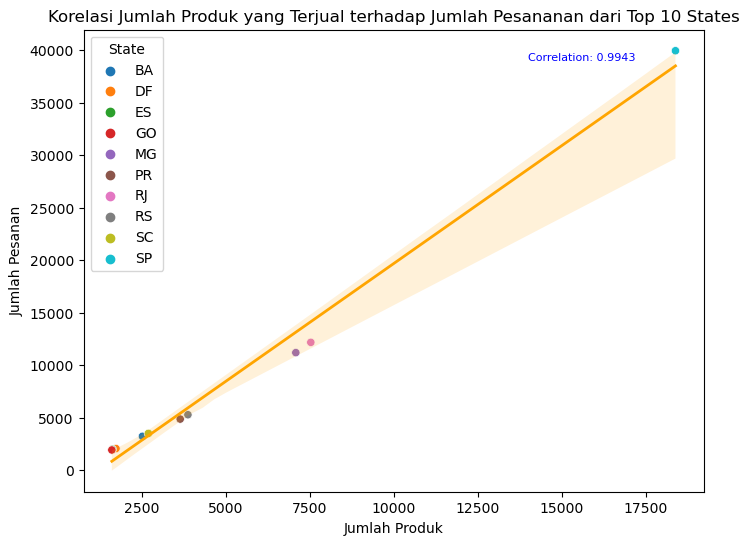

In [67]:
# Create a scatter plot using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=group_of_top_10_states, x='num_products', y='num_orders', hue='customer_state')

# Add the correlation line using Seaborn's regplot
sns.regplot(data=group_of_top_10_states, x='num_products', y='num_orders', scatter=False, color='orange', line_kws={"linewidth": 2})

# Customize the plot (optional)
plt.title('Korelasi Jumlah Produk yang Terjual terhadap Jumlah Pesananan dari Top 10 States')
plt.xlabel('Jumlah Produk')
plt.ylabel('Jumlah Pesanan')
plt.legend(title='State')

# Add the correlation coefficient as text to the plot
plt.text(14000, 39000, f'Correlation: {correlation_top_10_states:.4f}', fontsize=8, color='blue')

# Show the plot
plt.show()

In [68]:
# Calculate correlation coefficient for all states between num_orders and num_products

num_orders_all = grouped_data.loc[:,'num_orders']
num_products_all = grouped_data.loc[:,'num_products']

correlation_matrix = np.corrcoef(num_products_all, num_orders_all)
correlation_all = correlation_matrix[0, 1]

print(grouped_data)
print("Correlation:", correlation_all)

   customer_state  num_orders  num_products
0              AC          78            79
1              AL         393           361
2              AM         144           144
3              AP          67            69
4              BA        3214          2528
5              CE        1266          1065
6              DF        2050          1740
7              ES        1978          1631
8              GO        1911          1617
9              MA         709           648
10             MG       11187          7091
11             MS         692           640
12             MT         874           832
13             PA         928           849
14             PB         509           474
15             PE        1575          1304
16             PI         469           439
17             PR        4855          3651
18             RJ       12166          7537
19             RN         468           430
20             RO         238           245
21             RR          39   

#### **Q5: Korelasi Jumlah Produk yang Terjual terhadap Jumlah Pesananan dari All States**

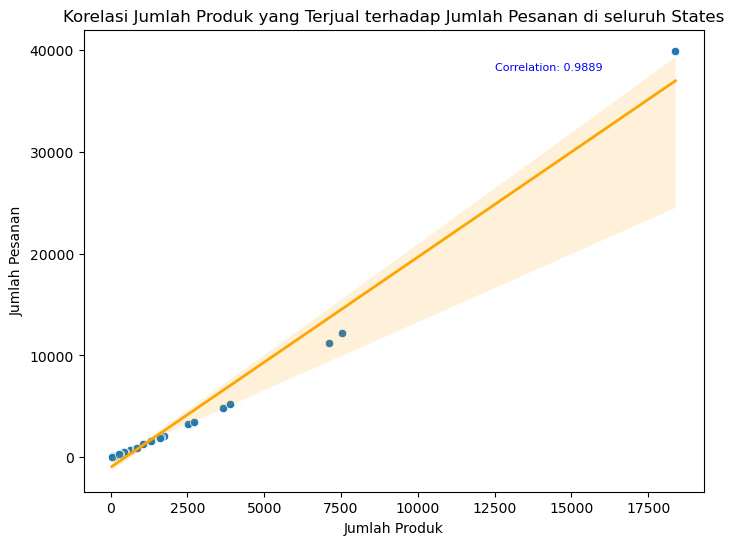

In [69]:
# Create a scatter plot using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=grouped_data, x='num_products', y='num_orders')

# Add the correlation line using Seaborn's regplot
sns.regplot(data=grouped_data, x='num_products', y='num_orders', scatter=False, color='orange', line_kws={"linewidth": 2})

# Customize the plot (optional)
plt.title('Korelasi Jumlah Produk yang Terjual terhadap Jumlah Pesanan di seluruh States')
plt.xlabel('Jumlah Produk')
plt.ylabel('Jumlah Pesanan')

# Add the correlation coefficient as text to the plot
plt.text(12500, 38000, f'Correlation: {correlation_all:.4f}', fontsize=8, color='blue')

# Show the plot
plt.show()

#### **Q6: Apa saja 5 kategori produk penghasil revenue teratas di masing-masing dari 10 negara bagian tersebut?**

In [70]:
is_revenue_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103172 entries, 0 to 103171
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  103172 non-null  object        
 1   customer_id               103172 non-null  object        
 2   order_status              103172 non-null  object        
 3   order_purchase_timestamp  103172 non-null  datetime64[ns]
 4   customer_state            103172 non-null  object        
 5   payment_sequential        103172 non-null  float64       
 6   payment_type              103172 non-null  object        
 7   payment_installments      103172 non-null  float64       
 8   payment_value             103172 non-null  float64       
 9   product_id                103172 non-null  object        
 10  product_category          103172 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 8.7+ MB

In [111]:
# Membuat function untuk menghitung revenue per product category untuk top 10 states
# Menggunakan tabel ke-3 (revenue_products) dan state list sebagai suatu input
def calculate_revenue_per_product_cat(revenue_data, state_list):
    # Membuat empty dictionary untuk menyimpan summaries di setiap state
    revenue_by_state = {}
    
    # Iterasi melalui setiap state di state_list
    for state in state_list:
        # Filter data untuk current state
        state_data = revenue_data[revenue_data['customer_state'] == state]
        
        # Group by product category dan sum payment values
        revenue_summary = state_data.groupby('product_category')['payment_value'].sum().reset_index()
        
        # Menyimpan summary di dalam dictionary
        revenue_by_state[state] = revenue_summary
        
    return revenue_by_state

# Mengakses revenue summary dan menghitung proporsi revenue untuk top 10 states
def calculate_revenue_proportion(revenue_by_state_dict, state):
    # mengakses revenue summary untuk top 10 states
    state_summary = revenue_by_state_dict.get(state)

    if state_summary is not None:
        # Menghitung proporsi revenue
        state_summary['revenue_proportion'] = (state_summary['payment_value'] / state_summary['payment_value'].sum()) * 100
    
    state_summary.columns = ['product_category', 'revenue', 'revenue_proportion']
    return state_summary

# Membuat function untuk mengsortir revenue per product category berdasarkan highest revenue
def sort_by_highest_revenue(revenue_summary):
    # mengsortir summary berdasarkan highest revenue dalam descending order
    sorted_summary = revenue_summary.sort_values(by='revenue', ascending=False)
    sorted_summary = sorted_summary.head(5).reset_index(drop=True)
    return sorted_summary

# Membuat function untuk mengsortir revenue per product category berdasarkan lowest revenue
def sort_by_lowest_revenue(revenue_summary):
    # mengsortir summary berdasarkan lowest revenue dalam ascending order
    sorted_summary = revenue_summary.sort_values(by='revenue', ascending=True)
    sorted_summary = sorted_summary.head(5).reset_index(drop=True)
    return sorted_summary

# Top 10 states dengan highest revenue
top_10_states = ['SP','RJ','MG','RS','PR','SC','BA','DF','GO','ES']

# Menghitung revenue per product category untuk top 10 states
revenue_by_state_dict = calculate_revenue_per_product_cat(is_revenue_products, top_10_states)

In [72]:
sp_summary = calculate_revenue_proportion(revenue_by_state_dict, 'SP')
highest_sp_summary = sort_by_highest_revenue(sp_summary)
highest_sp_summary

,product_category,revenue,revenue_proportion
0,bed_bath_table,646481.77,10.616790
1,health_beauty,534209.43,8.773008
2,watches_gifts,466060.17,7.653832
3,sports_leisure,450930.65,7.405369
4,computers_accessories,416581.36,6.841271


In [73]:
rj_summary = calculate_revenue_proportion(revenue_by_state_dict, 'RJ')
highest_rj_summary = sort_by_highest_revenue(rj_summary)
highest_rj_summary

,product_category,revenue,revenue_proportion
0,bed_bath_table,210439.76,9.771637
1,watches_gifts,199439.29,9.260837
2,health_beauty,164879.49,7.656075
3,computers_accessories,149665.28,6.949612
4,sports_leisure,144618.68,6.715277


In [74]:
mg_summary = calculate_revenue_proportion(revenue_by_state_dict, 'MG')
highest_mg_summary = sort_by_highest_revenue(mg_summary)
highest_mg_summary

,product_category,revenue,revenue_proportion
0,bed_bath_table,180645.67,9.480303
1,health_beauty,179475.38,9.418886
2,watches_gifts,135518.20,7.112009
3,computers_accessories,133615.01,7.012129
4,sports_leisure,132687.85,6.963472


In [75]:
rs_summary = calculate_revenue_proportion(revenue_by_state_dict, 'RS')
highest_rs_summary = sort_by_highest_revenue(rs_summary)
highest_rs_summary

,product_category,revenue,revenue_proportion
0,bed_bath_table,84737.34,9.402476
1,furniture_decor,74042.52,8.215776
2,computers_accessories,66849.60,7.417648
3,sports_leisure,62281.37,6.910756
4,health_beauty,61151.37,6.785371


In [76]:
pr_summary = calculate_revenue_proportion(revenue_by_state_dict, 'PR')
highest_pr_summary = sort_by_highest_revenue(pr_summary)
highest_pr_summary

,product_category,revenue,revenue_proportion
0,furniture_decor,73966.95,9.022799
1,sports_leisure,68886.50,8.403064
2,watches_gifts,63847.51,7.788387
3,bed_bath_table,63518.33,7.748233
4,health_beauty,62190.89,7.586306


In [77]:
sc_summary = calculate_revenue_proportion(revenue_by_state_dict, 'SC')
highest_sc_summary = sort_by_highest_revenue(sc_summary)
highest_sc_summary

,product_category,revenue,revenue_proportion
0,sports_leisure,52620.42,8.449149
1,health_beauty,46938.64,7.536837
2,computers_accessories,44118.92,7.084081
3,furniture_decor,43402.17,6.968994
4,bed_bath_table,43119.15,6.923550


In [78]:
ba_summary = calculate_revenue_proportion(revenue_by_state_dict, 'BA')
highest_ba_summary = sort_by_highest_revenue(ba_summary)
highest_ba_summary

,product_category,revenue,revenue_proportion
0,health_beauty,61813.48,10.012377
1,watches_gifts,51464.50,8.336078
2,sports_leisure,45827.14,7.422954
3,computers_accessories,39871.80,6.458324
4,bed_bath_table,35425.48,5.738122


In [79]:
df_summary = calculate_revenue_proportion(revenue_by_state_dict, 'DF')
highest_df_summary = sort_by_highest_revenue(df_summary)
highest_df_summary

,product_category,revenue,revenue_proportion
0,watches_gifts,36147.40,9.763556
1,health_beauty,35212.68,9.511085
2,computers_accessories,34857.50,9.415149
3,sports_leisure,29201.03,7.887314
4,bed_bath_table,23031.32,6.220851


In [80]:
go_summary = calculate_revenue_proportion(revenue_by_state_dict, 'GO')
highest_go_summary = sort_by_highest_revenue(go_summary)
highest_go_summary

,product_category,revenue,revenue_proportion
0,bed_bath_table,34504.80,9.889907
1,watches_gifts,34455.51,9.875779
2,health_beauty,33766.77,9.678370
3,sports_leisure,23241.78,6.661654
4,housewares,21089.88,6.044868


In [81]:
es_summary = calculate_revenue_proportion(revenue_by_state_dict, 'ES')
highest_es_summary = sort_by_highest_revenue(es_summary)
highest_es_summary

,product_category,revenue,revenue_proportion
0,watches_gifts,31632.25,9.533084
1,bed_bath_table,29737.08,8.961932
2,sports_leisure,25065.14,7.553939
3,health_beauty,24195.60,7.291883
4,furniture_decor,19266.90,5.806510


In [82]:
top_10_states = ['SP','RJ','MG','RS','PR','SC','BA','DF','GO','ES']

In [83]:
# Membuat subplot dengan 5 rows dan 2 columns
fig = make_subplots(rows=5, cols=2, subplot_titles=('Top 5 revenue-generating product SP', 'Top 5 revenue-generating product RJ', 'Top 5 revenue-generating product MG', 'Top 5 revenue-generating product RS', 'Top 5 revenue-generating product PR', 'Top 5 revenue-generating product SC', 'Top 5 revenue-generating product BA', 'Top 5 revenue-generating product DF', 'Top 5 revenue-generating product GO', 'Top 5 revenue-generating product ES'))

# Add Plotly Express plots to each subplot
fig.add_trace(px.bar(highest_sp_summary, x='product_category', y='revenue').data[0], row=1, col=1)
fig.add_trace(px.bar(highest_rj_summary, x='product_category', y='revenue').data[0], row=1, col=2)
fig.add_trace(px.bar(highest_mg_summary, x='product_category', y='revenue').data[0], row=2, col=1)
fig.add_trace(px.bar(highest_rs_summary, x='product_category', y='revenue').data[0], row=2, col=2)
fig.add_trace(px.bar(highest_pr_summary, x='product_category', y='revenue').data[0], row=3, col=1)
fig.add_trace(px.bar(highest_sc_summary, x='product_category', y='revenue').data[0], row=3, col=2)
fig.add_trace(px.bar(highest_ba_summary, x='product_category', y='revenue').data[0], row=4, col=1)
fig.add_trace(px.bar(highest_df_summary, x='product_category', y='revenue').data[0], row=4, col=2)
fig.add_trace(px.bar(highest_go_summary, x='product_category', y='revenue').data[0], row=5, col=1)
fig.add_trace(px.bar(highest_es_summary, x='product_category', y='revenue').data[0], row=5, col=2)

# Update subplot titles (opsional)
fig.update_layout(title_text='Apa saja 5 kategori produk penghasil revenue teratas di masing-masing dari 10 negara bagian tersebut?',
                  autosize=False,
                  width=800,
                  height=1000)

# Menampilkan plot
fig.show()